In [1]:
# Convert image stacks to zarr
import pathlib

import zarr
from ml4paleo.volume_providers import ImageStackVolumeProvider
import tqdm
from numcodecs import Blosc

In [2]:
image_path = pathlib.Path(
    "/Volumes/Elements/Burrow full scan BP_1_5558_45.5um_16bits"
)
zarr_path = pathlib.Path("../data/Burrow_Images.zarr")
image_stack = ImageStackVolumeProvider(image_path, "**/*.tif")

In [3]:
image_stack.shape

(2524, 3369, 6221)

In [8]:
# new_zarr_file = zarr.open(
#     str(zarr_path),
#     mode="w",
#     shape=[int(i / 4) for i in image_stack.shape],
#     chunks=(128, 128, 128),
#     dtype="uint16",
#     compressor=Blosc()
# )

Z_CHUNK = 64

for z_start in tqdm.tqdm(range(0, image_stack.shape[2], Z_CHUNK)):    
    z_max_chunk = min(z_start + Z_CHUNK, image_stack.shape[2])
    stack = image_stack[:, :, z_start:z_max_chunk][::4, ::4, ::4][:,:-1,:]
    downsized_z_start = int(z_start / 4)
    downsized_z_max_chunk = stack.shape[2] + downsized_z_start
    new_zarr_file[:, :, downsized_z_start:downsized_z_max_chunk] = stack


  0%|          | 0/1 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [42]:
seg_path = pathlib.Path("/Users/mateljk1/Documents/projects/ml4paleo/data/Burrow AI ground truth stack")
zarr_seg_path = pathlib.Path("../data/Burrow_Segmentation.mip2.zarr")
seg_stack = ImageStackVolumeProvider(seg_path, "**/*.jpg", cache_size=7000)


In [43]:
seg_stack.shape

(2524, 3369, 6221)

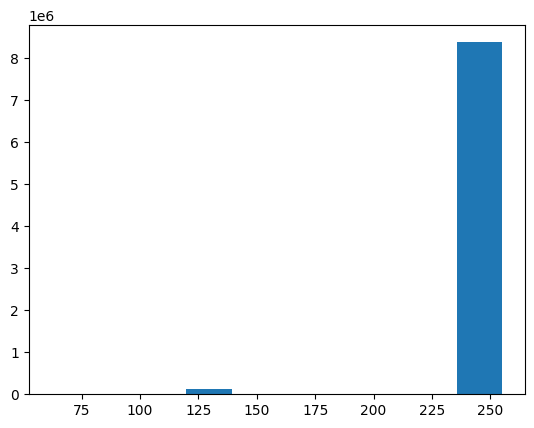

In [44]:
# Histogram:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.ravel(seg_stack[:,:,3525]))
plt.show()

In [45]:
seg_zarr_file = zarr.open(
    str(zarr_seg_path),
    mode="w",
    write_empty_chunks=False,
    shape=[int(i / 4) for i in seg_stack.shape],
    chunks=(128, 128, 128),
    dtype="bool",
    compressor=Blosc()
)


In [46]:
seg_stack[:,:,3525].min()

62

In [49]:
Z_CHUNK = 128

for z_start in tqdm.tqdm(range(0, seg_stack.shape[2], Z_CHUNK)):    
    z_max_chunk = min(z_start + Z_CHUNK, seg_stack.shape[2])
    # stack = seg_stack[:, :, z_start:z_max_chunk][::4, ::4, ::4][:,:-1,:]
    big_stack = seg_stack[:, :, z_start:z_max_chunk]
    stack = big_stack[::4, ::4, ::4][:,:-1,:]
    downsized_z_start = int(z_start / 4)
    downsized_z_max_chunk = stack.shape[2] + downsized_z_start
    # binarize the segmentation
    stack[stack <= 200] = 1
    stack[stack > 200] = 0
    seg_zarr_file[:, :, downsized_z_start:downsized_z_max_chunk] = stack


 98%|█████████▊| 48/49 [11:37<00:14, 14.53s/it]


ValueError: parameter 'value': expected array with shape (631, 842, 19), got (631, 842, 20)